In [1]:
import numpy as np
import pandas as pd
import keras.optimizers as opt
import utils_data as ud
import utils_info as info
import constants as cons
import utils_matrixes as um
from matplotlib import pyplot as plt
from keras.models import Sequential
from keras import layers
import time
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# import warnings
# warnings.filterwarnings('ignore')
# warnings.filterwarnings('ignore', category=DeprecationWarning)

start_time = time.time()

'''
    General settings
'''

target_name = cons.TIMESERIES_TARGET_NAME
residual_target_name = cons.RESIDUAL_TARGET_NAME
temperature_name = cons.TEMPERATURE_NAME
source_folder = cons.SOURCE_FILES_FOLDER
calendar_folder = cons.CALENDAR_FOLDER
forecast_folder = cons.FORECAST_FILE_FOLDER
model_folder = cons.MODEL_FOLDER
benchmark_folder = cons.BENCHMARK_FOLDER
log_folder = cons.LOGS_FOLDER

company = 'Company'
hub = 'HUB3'                

model_info = info.get_model_info(company, hub)

'''

Model settings to be saved

'''

min_lag_une = 192
model_settings = info.get_model_settings_network(company, hub, min_lag_une)

'''

Training settings

'''

save_model = True  # put True when ready to write
save_benchmark = True

date_start = model_settings['train_date_start']
date_end = model_settings['train_date_end']

t = pd.date_range(date_start, model_settings['train_date_split'], freq='D')
neurons_number_layer_dense1 = model_settings['network_train_settings']['neurons_number_layer_dense']
batch_size = model_settings['network_train_settings']['batch_size']
network_epochs = model_settings['network_train_settings']['network_epochs']
learning_rate_setting = model_settings['network_train_settings']['learning_rate_setting']
custom_loss = model_settings['network_train_settings']['custom_loss']
activation_function = model_settings['network_train_settings']['activation_function']
print(model_settings['simple_lags_settings'])
# Optional settings
if 'batch_normalization' in model_settings['network_train_settings']:
    bn = model_settings['network_train_settings']['batch_normalization']
else:
    bn = False

if 'horison' in model_settings['network_train_settings']:
    horison = model_settings['network_train_settings']['horison']
else:
    horison = cons.FORECAST_HORISON

max_lag = (model_settings['simple_lags_settings'][-1]/24).astype(int)
train_split_index = len(t) * int(cons.FORECAST_HORISON / horison) -  max_lag

benchmark_modelname = hub + '_lags_' + str(model_settings['min_lag']) + '_network_train_result.xlsx'
benchmark_filename = ud.get_filename(benchmark_folder, company, hub, benchmark_modelname)
benchmark_sheetname = 'dense'

'''
    Main
'''

data = ud.get_data(model_info['actuals_filename'], date_start, date_end, model_info['actuals_dateformat'])

if 'temperature' in model_settings['weather_settings']:
    temperature = ud.get_data(model_info['temperature_actuals_filename'],
                              date_start, date_end, model_info['temperature_actuals_dateformat'])
    data = ud.add_temperature(data, temperature, model_settings['temperature_settings'])

data, model_settings, predictors_name, target_name = \
    um.get_network_input_matrix(data, model_info, model_settings, date_start, date_end)
data = ud.clean_data(data)

'''
Correlation plot
'''

# corr = data.corr()
# f, ax = plt.subplots(figsize=(20, 20))
# cmap = sns.diverging_palette(220, 10, as_cmap=True)
# sns.heatmap(corr, cmap=cmap, vmax=.3, center=0,
#             square=True, linewidths=.5, cbar_kws={"shrink": .5})
# plt.show()

'''
 Scale and split the data
'''

data_array_scaled, model_settings['scaler'] = ud.do_normalisation(data, model_settings['scaler'])

predictors = data_array_scaled.values[:, data.columns.isin(predictors_name)]
target = data_array_scaled.values[:, data.columns.isin(pd.Index([target_name]))]
dates = data.index.values

predictors = predictors.reshape(-1, horison, predictors.shape[1])
target = target.reshape(-1, horison)
dates = dates.reshape(-1, horison)

train_predictors = predictors[:train_split_index]
train_target = target[:train_split_index]
train_dates = dates[:train_split_index]

valid_predictors = predictors[train_split_index:]
valid_target = target[train_split_index:]
valid_dates = dates[train_split_index:]

print('Shape of train predictors: ', train_predictors.shape)
print('Shape of validation predictors: ', valid_predictors.shape)

'''
    Model
'''

network = Sequential()

# LSTM
# network.add(layers.LSTM(neurons_number_layer_dense1, return_sequences=False,
# input_shape=(horison, predictors.shape[-1])))
# network.add(layers.Dense(horison, activation='linear'))

# Dense
network.add(layers.Flatten(input_shape=(horison, predictors.shape[-1])))
if bn:
    network.add(layers.Dense(neurons_number_layer_dense1))
    network.add(layers.BatchNormalization())
    network.add(layers.Activation(activation=activation_function))
else:
    network.add(layers.Dense(neurons_number_layer_dense1, activation=activation_function))
network.add(layers.Dense(horison))

custom_optimiser = opt.Adam(lr=learning_rate_setting)
network.compile(optimizer=custom_optimiser, loss=custom_loss)
history = network.fit(train_predictors, train_target,
                      epochs=network_epochs,
                      batch_size=batch_size, verbose=0,
                      validation_data=(valid_predictors, valid_target))

'''
    Assess train results
'''

model_settings['network'] = network

network.summary()

model_target = network.predict(valid_predictors)

model_target = model_target.reshape(-1, 1)
valid_target = valid_target.reshape(-1, 1)
valid_dates = valid_dates.reshape(-1, 1).ravel()

if model_settings['target'] == 'residual':
    model_target = pd.DataFrame(model_target, columns=[cons.RESIDUAL_TARGET_NAME])
else:
    model_target = pd.DataFrame(model_target, columns=[cons.TIMESERIES_TARGET_NAME])

model_target = ud.undo_normalisation(model_target, model_settings['scaler'])

mask = data.index.isin(valid_dates)
valid_target = data[cons.TIMESERIES_TARGET_NAME][mask].values

if model_settings['target'] == 'residual':
    model_target = data['global_trend'][mask].values + model_target.values.ravel()
else:
    model_target = model_target.values.ravel()

ud.get_accuracy(model_target, valid_target)

'''

Autoregression

'''

model_full = network.predict(predictors)
model_full = model_full.reshape(-1, 1)
model_full = pd.DataFrame(model_full, columns=[target_name])
model_full = ud.undo_normalisation(model_full, model_settings['scaler'])
dates = dates.reshape(-1, 1).ravel()
mask = data.index.isin(dates)

if model_settings['target'] == 'residual':
    model_full = data['global_trend'][mask].values + model_full.values.ravel()
else:
    model_full = model_full.values.ravel()

prediction = np.zeros(len(data))
prediction[mask] = model_full
data['prediction'] = prediction
data, model_settings, pred_name = um.get_autoregress_results(data, model_settings, 'train')

# f, axarr = plt.subplots(3, sharex=True, sharey=False)
# f.suptitle('Consumption: train results')
# axarr[0].plot(data.index, data[cons.TIMESERIES_TARGET_NAME])
# axarr[0].plot(data.index, data[pred_name])
# axarr[1].plot(data.index, data['temperature'], '-r')
# axarr[2].plot(data.index, data['temperature'])
# f.subplots_adjust(hspace=0.01)
# for ax in axarr:
#     ax.label_outer()
# plt.show()


'''
    Saving model when training is done

'''

if save_benchmark:
    cmp_df = data[[cons.TIMESERIES_TARGET_NAME, pred_name]].copy()
    cmp_df.rename(columns={cons.TIMESERIES_TARGET_NAME: 'Fact', pred_name: 'Prediction'}, inplace=True)
    cmp_df.index.name = cons.TIMESTEP_NAME
    # mask = cmp_df.index >= pd.datetime(2012, 1, 29)
    # cmp_df[mask].to_excel(benchmark_filename, sheet_name=benchmark_sheetname)
    cmp_df.to_excel(benchmark_filename, sheet_name=benchmark_sheetname)

if save_model:
    ud.save_model_settings(model_settings, company, hub, 'network')

print("--- %s seconds ---" % (time.time() - start_time))

Using TensorFlow backend.


[192 336 504 672]
Shape of train predictors:  (1949, 24, 61)
Shape of validation predictors:  (1, 24, 61)
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 1464)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 96)                140640    
_________________________________________________________________
dense_2 (Dense)              (None, 24)                2328      
Total params: 142,968
Trainable params: 142,968
Non-trainable params: 0
_________________________________________________________________
Accuracy: MAE =  5.24  MWh,  MAPE =  1.20 %, MaxAPE =  2.96 %, APE > 5 =  0.00 %
Step_24:
Accuracy: MAE =  8.23  MWh,  MAPE =  1.97 %, MaxAPE =  23.11 %, APE > 5 =  7.26 %
Ac

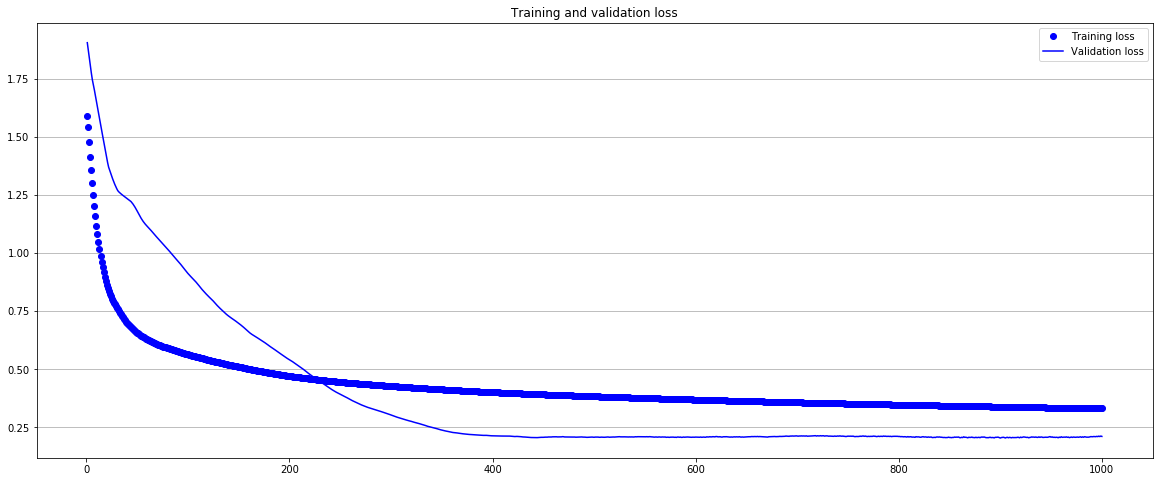

In [2]:
'''
 Loss plot
'''

loss = np.array(history.history['loss'])
val_loss = np.array(history.history['val_loss'])
epochs = range(1, len(loss) + 1)
plt.figure(figsize=(20, 8))
plt.plot(epochs, loss[:], 'bo', label='Training loss')
plt.plot(epochs, val_loss[:], 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.grid(True, axis='y')
plt.show()
# plt.savefig('Loss plots/loss_' + hub + 'residual_best.png')

In [3]:
valid_dates

array(['2019-10-30T00:00:00.000000000', '2019-10-30T01:00:00.000000000',
       '2019-10-30T02:00:00.000000000', '2019-10-30T03:00:00.000000000',
       '2019-10-30T04:00:00.000000000', '2019-10-30T05:00:00.000000000',
       '2019-10-30T06:00:00.000000000', '2019-10-30T07:00:00.000000000',
       '2019-10-30T08:00:00.000000000', '2019-10-30T09:00:00.000000000',
       '2019-10-30T10:00:00.000000000', '2019-10-30T11:00:00.000000000',
       '2019-10-30T12:00:00.000000000', '2019-10-30T13:00:00.000000000',
       '2019-10-30T14:00:00.000000000', '2019-10-30T15:00:00.000000000',
       '2019-10-30T16:00:00.000000000', '2019-10-30T17:00:00.000000000',
       '2019-10-30T18:00:00.000000000', '2019-10-30T19:00:00.000000000',
       '2019-10-30T20:00:00.000000000', '2019-10-30T21:00:00.000000000',
       '2019-10-30T22:00:00.000000000', '2019-10-30T23:00:00.000000000'],
      dtype='datetime64[ns]')